In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas.core.frame import DataFrame

filename = 'healthcare-dataset-stroke-data.csv'
cols = ['gender','age','hypertension','heart_disease','ever_married', 'work_type', 'Residence_type','avg_glucose_level','bmi', 'smoking_status','stroke']

df = pd.read_csv(filename, usecols=cols)

In [201]:
# Check datatype each column of dataframe
cat_df = df.select_dtypes(include=['object'])
num_df = df.select_dtypes(exclude=['object'])

def printColumnTypes(non_numeric_df: DataFrame, numeric_df: DataFrame):
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_numeric_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in numeric_df:
        print(f"{col}")

printColumnTypes(cat_df, num_df)

Non-Numeric columns:
gender
ever_married
work_type
Residence_type
smoking_status

Numeric columns:
age
hypertension
heart_disease
avg_glucose_level
bmi
stroke


In [202]:
df.describe(include='all')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [204]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Terdapat Missing Value pada Attribute BMI
Hal ini ditandakan pada kolom bmi terdapat 201 missing value

In [205]:
def print_unique_value(cols: list):
    for col in cols:
        print(f"{col}: {df[col].unique()}")
        
non_numeric_col = ['gender','ever_married','work_type','Residence_type', 'smoking_status']

print_unique_value(non_numeric_col)

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [206]:
def print_percentage_data(dataframe, cols: list[str] | str):
    if type(cols) == str:
        print(dataframe[cols].value_counts() / len(dataframe))
        return

    for col in cols:
        print(dataframe[col].value_counts() / len(dataframe))
        print()

print_percentage_data(df, non_numeric_col)

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64



### Pra-process
- Data Cleansing
- Remove Outlier
- Label Encoding

In [207]:
mean_bmi_replacement_value = df.loc[:,'bmi'].dropna().mean()
df['bmi'] = df.loc[:, 'bmi'].fillna(mean_bmi_replacement_value)

df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [208]:
modus_smoking_status = df['smoking_status'].max()
df['smoking_status'] = df['smoking_status'].apply(lambda x: modus_smoking_status if x == 'Unknown' else x)

df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes'], dtype=object)

In [209]:
print_percentage_data(df, 'smoking_status')

smokes             0.456556
never smoked       0.370254
formerly smoked    0.173190
Name: smoking_status, dtype: float64


In [210]:
df = df[df['gender'] != 'Other']

print_percentage_data(df, 'gender')

Female    0.586025
Male      0.413975
Name: gender, dtype: float64


In [211]:
num_gender = { 'Female': 0, 'Male': 1 }
num_ever_married = { 'No': 0, 'Yes': 1 }
num_smoking_status = {
    'formerly smoked': 0,
    'never smoked': 1,
    'smokes': 2,
}

num_work_type = {
    'children': 0,
    'Govt_job': 1,
    'Never_worked': 2,
    'Private': 3,
    'Self-employed': 4,
}
num_residence_type = {
    'Urban': 0,
    'Rural': 1
}

# Label Encoding
df['gender'] = df['gender'].replace(num_gender)
df['ever_married'] = df['ever_married'].replace(num_ever_married)
df['Residence_type'] = df['Residence_type'].replace(num_residence_type)
df['smoking_status'] = df['smoking_status'].replace(num_smoking_status)
df['work_type'] = df['work_type'].replace(num_work_type)

In [212]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,3,0,228.69,36.600000,0,1
1,0,61.0,0,0,1,4,1,202.21,28.893237,1,1
2,1,80.0,0,1,1,3,1,105.92,32.500000,1,1
3,0,49.0,0,0,1,3,0,171.23,34.400000,2,1
4,0,79.0,1,0,1,4,1,174.12,24.000000,1,1


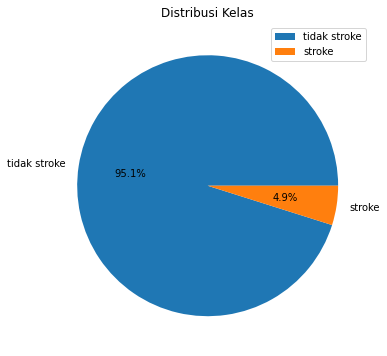

In [213]:
stroke_value_count = df['stroke'].value_counts()
replace_index = ["tidak stroke" if i == 0 else "stroke" for i in stroke_value_count.index]

plt.figure(figsize=(6, 6))
plt.pie(stroke_value_count.values,labels=replace_index, autopct='%1.1f%%')
plt.title('Distribusi Kelas')
plt.legend()
plt.show()

In [214]:
X = df.iloc[:, df.columns != 'stroke']
y = df.stroke

X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,3,0,228.69,36.600000,0
1,0,61.0,0,0,1,4,1,202.21,28.893237,1
2,1,80.0,0,1,1,3,1,105.92,32.500000,1
3,0,49.0,0,0,1,3,0,171.23,34.400000,2
4,0,79.0,1,0,1,4,1,174.12,24.000000,1
...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,3,0,83.75,28.893237,1
5106,0,81.0,0,0,1,4,0,125.20,40.000000,1
5107,0,35.0,0,0,1,4,1,82.99,30.600000,1
5108,1,51.0,0,0,1,3,1,166.29,25.600000,0


### **Membuat function melakukan visualisasi distribusi kelas**

Visualisasi dilakukan menggunakan library  `Matplotlib`
Untuk mempermudah akan dibentuk dalam 1 function 
```python 
def viz_distribution_of_class(X,y, col_idx, title) 
```

| Parameter | Deskripsi | Data Type |
| --------- | --------- | --------- |
| X | Fitur pada dataset | Numpy Array | 
| y | Kelas pada dataset | Numpy Array |
| col_idx | index column yang merepresentasikan dataset | Tupple [0, 1] |
| title | Title Visualisasi (default "") | String / None |


In [215]:
from collections import Counter
from matplotlib import pyplot
from numpy import where


def viz_distribution_of_class(X, y, col_idx, title="") -> None:
    plt = pyplot
    counter = Counter(y)
    print(counter)
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y != label)[0]
        plt.title(title)
        plt.scatter(X[row_ix, col_idx[0]], X[row_ix, col_idx[1]], label=str(label))
        plt.legend()
    plt.show()

### Visualisasi Distribusi kelas sebelum dilakukan resampling

Counter({0: 4860, 1: 249})


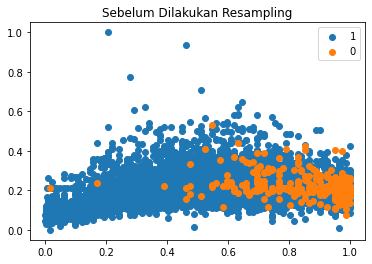

In [216]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

viz_distribution_of_class(X_scaled, y, [1,8], title="Sebelum Dilakukan Resampling")

### Visualisasi Distribusi Kelas Setelah dilakukan SMOTE

Counter({1: 4860, 0: 4860})


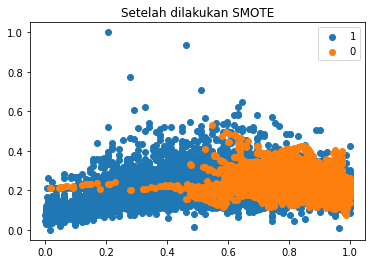

In [217]:
from imblearn.over_sampling import SMOTE

sm_oversampl = SMOTE()
X_oversampling, y_oversampling = sm_oversampl.fit_resample(X_scaled, y)

viz_distribution_of_class(X_oversampling, y_oversampling, [1,8], title="Setelah dilakukan SMOTE")

### Visualisasi Distribusi Kelas Setelah dilakukan SMOTE + TomekLink

Counter({0: 4860, 1: 4793})


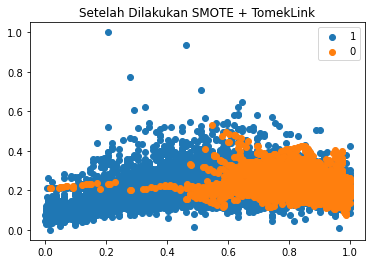

In [218]:
from imblearn.under_sampling import TomekLinks


tomekLink = TomekLinks()
X_tomekLink, y_tomekLink = tomekLink.fit_resample(X_oversampling, y_oversampling)

viz_distribution_of_class(X_tomekLink, y_tomekLink, [1,8], title="Setelah Dilakukan SMOTE + TomekLink")

### Visualisasi Distribusi Kelas Setelah dilakukan SMOTE + ENN

Counter({0: 4860, 1: 4359})


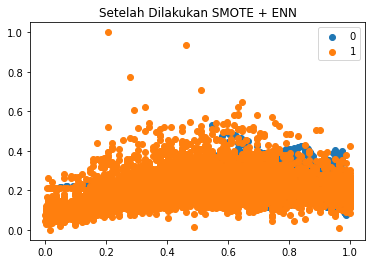

In [219]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(X_oversampling, y_oversampling)

viz_distribution_of_class(X_enn, y_enn, [1,8], title="Setelah Dilakukan SMOTE + ENN")

### **Process Evaluasi Model Menggunakan 10-cross-validation**

1. Tanpa Seleksi Fitur Information Gain :
    - SMOTE
    - SMOTE + TomekLink
    - SMOTE + ENN

2. Menggunakan Seleksi Fitur Information Gain :
    - SMOTE
    - SMOTE + TomekLink
    - SMOTE + ENN

Evaluasi Model berupa :
- F-measure
- ROC / AUC

Source Belajar : 
1. [SMOTE for imbalanced dataset](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [220]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Resampling 
oversampling = SMOTE(random_state=42)
tl = TomekLinks()
enn = EditedNearestNeighbours(sampling_strategy="all")

model = KNeighborsClassifier(n_neighbors=3 ,weights='distance', metric='euclidean')

pipeline_smote = Pipeline(steps = [
    ['over', oversampling],
    ['classifier', model]
])

pipeline_smote_tomek = Pipeline(steps = [
    ['over', oversampling],
    ['tomek', tl],
    ['classifier', model],
])

pipeline_smote_enn = Pipeline(steps = [
    ['over', oversampling],
    ['enn', enn],
    ['classifier', model],
])

cv = KFold(n_splits=10,random_state=1, shuffle=True)

scores_smote = cross_validate(pipeline_smote, X_scaled, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
scores_smote_tomek = cross_validate(pipeline_smote_tomek, X_scaled, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
scores_smote_enn = cross_validate(pipeline_smote_enn, X_scaled, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)

def print_scores(scores, title: str=''):
    print(title)
    for key in scores:
        print(f"{key}: {np.mean(scores[key])}")
    print("\n")

print_scores(scores_smote, 'evaluasi 10 cross validation SMOTE')
print_scores(scores_smote_tomek, 'evaluasi 10 cross validation SMOTE-TomekLinks')
print_scores(scores_smote_enn, 'evaluasi 10 cross validation SMOTE-ENN')

evaluasi 10 cross validation SMOTE
fit_time: 0.13080720901489257
score_time: 0.4326322078704834
test_accuracy: 0.8404830973485284
test_precision: 0.09318988618289166
test_recall: 0.2616871435300524
test_f1: 0.13505314341256602
test_roc_auc: 0.6217317418678314


evaluasi 10 cross validation SMOTE-TomekLinks
fit_time: 1.387191390991211
score_time: 0.13580636978149413
test_accuracy: 0.8432228233759258
test_precision: 0.0947842656281978
test_recall: 0.2616871435300524
test_f1: 0.1366529940819034
test_roc_auc: 0.61739797612847


evaluasi 10 cross validation SMOTE-ENN
fit_time: 1.231711983680725
score_time: 0.08996808528900146
test_accuracy: 0.7901830321169563
test_precision: 0.10964408431831321
test_recall: 0.4677871403472693
test_f1: 0.1754255234700102
test_roc_auc: 0.6668270895863582




## Percobaan Evaluasi model dengan tambahan Seleksi Fitur

Seleksi Fitur : **Information Gain**

Source Belajar :
1. [How to implement Information Gain using python](https://www.youtube.com/watch?v=81JSbXZ26Ls&ab_channel=KrishNaik)

In [221]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

mutual_info = mutual_info_classif(X_scaled, y, random_state=1)
mutual_info = pd.Series(mutual_info)
mutual_info.index = df.iloc[:, df.columns != 'stroke'].columns
mutual_info.sort_values(ascending=False)

# 
# ig_zipped = zip(df.iloc[:, df.columns != 'stroke'].columns, mutual_info_classif(X_scaled,y, random_state=1))
# ig_df = pd.DataFrame(sorted(ig_zipped, key=lambda x: x[1], reverse=True), columns=['Features', 'entrophy'])
# ig_df


age                  0.034485
bmi                  0.010441
work_type            0.006693
ever_married         0.006379
avg_glucose_level    0.006238
heart_disease        0.004897
gender               0.004171
hypertension         0.003540
smoking_status       0.001582
Residence_type       0.000740
dtype: float64

<Axes: >

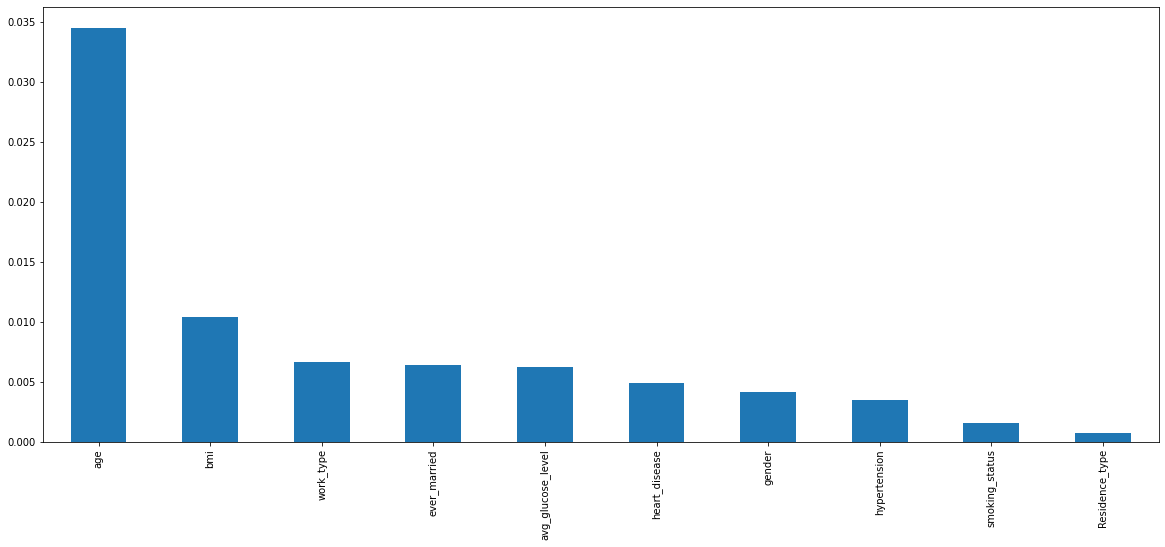

In [222]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [223]:
from sklearn.feature_selection import SelectKBest

In [235]:
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_scaled, y)

X_ig = pd.DataFrame(X_scaled, columns=X.columns).iloc[:, sel_five_cols.get_support()]
X_ig.head(5)

,age,heart_disease,ever_married,avg_glucose_level,bmi
0,0.816895,1.0,1.0,0.801265,0.301260
1,0.743652,0.0,1.0,0.679023,0.212981
2,0.975586,1.0,1.0,0.234512,0.254296
3,0.597168,0.0,1.0,0.536008,0.276060
4,0.963379,0.0,1.0,0.549349,0.156930


In [234]:
oversampling = SMOTE(random_state=42)
tl = TomekLinks()
enn = EditedNearestNeighbours(sampling_strategy="all")

model = KNeighborsClassifier(n_neighbors=3 ,weights='distance', metric='euclidean')

pipeline_smote = Pipeline(steps = [
    ['over', oversampling],
    ['classifier', model]
])

pipeline_smote_tomek = Pipeline(steps = [
    ['over', oversampling],
    ['tomek', tl],
    ['classifier', model],
])

pipeline_smote_enn = Pipeline(steps = [
    ['over', oversampling],
    ['enn', enn],
    ['classifier', model],
])

cv = KFold(n_splits=10,random_state=1, shuffle=True)

scores_smote = cross_validate(pipeline_smote, X_ig, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
scores_smote_tomek = cross_validate(pipeline_smote_tomek, X_ig, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
scores_smote_enn = cross_validate(pipeline_smote_enn, X_ig, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)

def print_scores(scores, title: str=''):
    print(title)
    for key in scores:
        print(f"{key}: {np.mean(scores[key])}")
    print("\n")

print("After Selection Features")
print_scores(scores_smote, 'evaluasi 10 cross validation SMOTE')
print_scores(scores_smote_tomek, 'evaluasi 10 cross validation SMOTE-TomekLinks')
print_scores(scores_smote_enn, 'evaluasi 10 cross validation SMOTE-ENN')

After Selection Features
evaluasi 10 cross validation SMOTE
fit_time: 0.048962521553039554
score_time: 0.08837356567382812
test_accuracy: 0.8211066344345959
test_precision: 0.10389301214915592
test_recall: 0.3477924257965257
test_f1: 0.1584853983512039
test_roc_auc: 0.6455569685904653


evaluasi 10 cross validation SMOTE-TomekLinks
fit_time: 0.47016282081604005
score_time: 0.06302034854888916
test_accuracy: 0.8295230420935498
test_precision: 0.10391405309979737
test_recall: 0.3253623583405136
test_f1: 0.15609534367621133
test_roc_auc: 0.6419134047475594


evaluasi 10 cross validation SMOTE-ENN
fit_time: 0.37953274250030516
score_time: 0.05502057075500488
test_accuracy: 0.7633651816891139
test_precision: 0.11997958751519237
test_recall: 0.6037043491586671
test_f1: 0.19841896450937485
test_roc_auc: 0.7198874216729616




In [225]:
import math

def entropy(labels):
    entropy=0
    label_counts = Counter(labels)
    for label in label_counts:
        prob_of_label = label_counts[label] / len(labels)
        entropy -= prob_of_label * math.log2(prob_of_label)
    return entropy